In [28]:
%load_ext autoreload
%autoreload 2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image

import colorsys

import utils


BLACK = 0
WHITE = 255

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Benchmark Filtering Methods

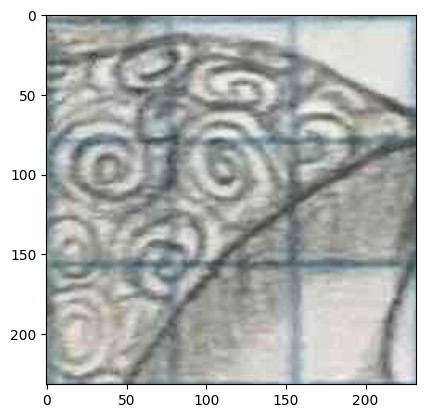

In [29]:
rgb_original = cv.cvtColor(cv.imread("data/grid_patch3.png"), cv.COLOR_BGR2RGB)
hls_original = cv.cvtColor(rgb_original, cv.COLOR_RGB2HLS)
plt.imshow(rgb_original)

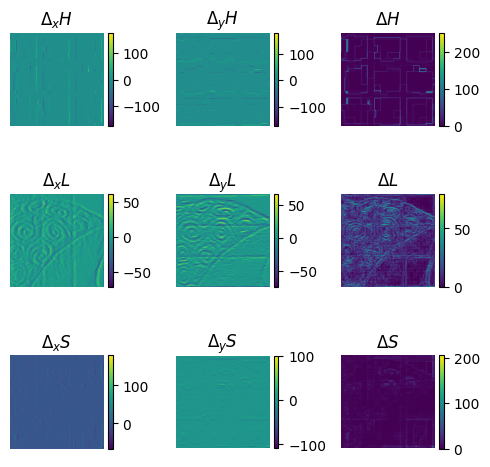

In [39]:
hue, luminance, saturation  = hls_original[..., 0].astype(int), hls_original[..., 1].astype(int), hls_original[..., 2].astype(int)
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

img0 = axs[0, 0].imshow(hue_dx := hue[:, 1:] - hue[:, :-1])
axs[0, 0].set_title("$\Delta_x H$")

img1 = axs[0, 1].imshow(hue_dy := hue[1:, :] - hue[:-1, :])
axs[0, 1].set_title("$\Delta_y H$")

img2 = axs[0, 2].imshow(np.sqrt(hue_dx[1:, :] ** 2 + hue_dy[:, 1:] ** 2))
axs[0, 2].set_title("$\Delta H$")

img3 = axs[1, 0].imshow(lum_dx := luminance[:, 1:] - luminance[:, :-1])
axs[1, 0].set_title("$\Delta_x L$")

img4 = axs[1, 1].imshow(lum_dy := luminance[1:, :] - luminance[:-1, :])
axs[1, 1].set_title("$\Delta_y L$")

img5 = axs[1, 2].imshow(np.sqrt(lum_dx[1:, :] ** 2 + lum_dy[:, 1:] ** 2))
axs[1, 2].set_title("$\Delta L$")

img6 = axs[2, 0].imshow(sat_dx := saturation[:, 1:] - saturation[:, :-1])
axs[2, 0].set_title("$\Delta_x S$")

img7 = axs[2, 1].imshow(sat_dy := saturation[1:, :] - saturation[:-1, :])
axs[2, 1].set_title("$\Delta_y S$")

img8 = axs[2, 2].imshow(np.sqrt(sat_dx[1:, :] ** 2 + sat_dy[:, 1:] ** 2))
axs[2, 2].set_title("$\Delta S$")

for ax, img in zip(axs.ravel(), (img0, img1, img2, img3, img4, img5, img6, img7, img8)):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

plt.tight_layout()

The only gradient that seems to pick up the image in the HSL color space is luminance. Hue and saturation both yield feint results that probably aren't worth exploring further for our task.

height=232
width=232


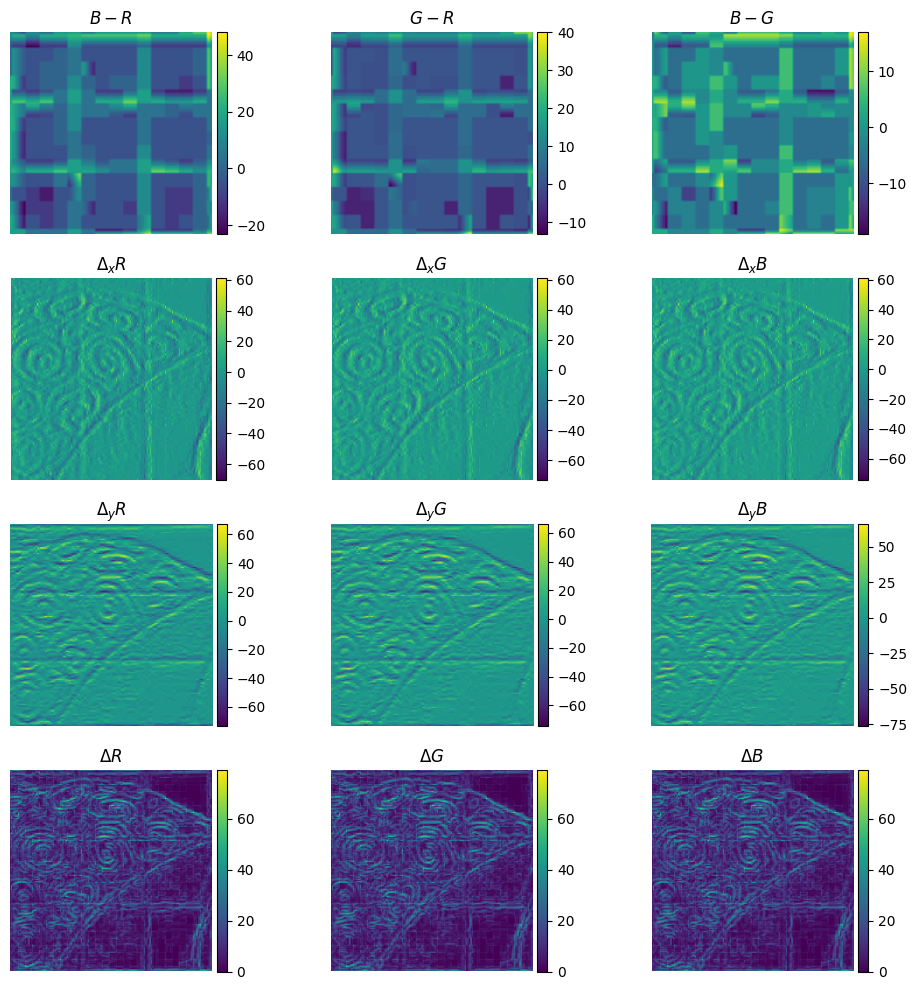

In [31]:
red, green, blue = rgb_original[..., 0].astype(int), rgb_original[..., 1].astype(int), rgb_original[..., 2].astype(int)
height, width = rgb_original.shape[:2]
print(f"{height=}\n{width=}")
fig, axs = plt.subplots(4, 3, figsize=(10, 10))

# differences
img0 = axs[0, 0].imshow(br_diff := blue - red)
axs[0, 0].set_title("$B - R$")

img1 = axs[0, 1].imshow(gr_diff := green - red)
axs[0, 1].set_title("$G - R$")

img2 = axs[0, 2].imshow(bg_diff := blue - green)
axs[0, 2].set_title("$B - G$")

# gradients
img3 = axs[1, 0].imshow(rx := red[:, 1:] - red[:, :-1])
axs[1, 0].set_title("$\Delta_x R$")

img4 = axs[1, 1].imshow(gx := green[:, 1:] - green[:, :-1])
axs[1, 1].set_title("$\Delta_x G$")

img5 = axs[1, 2].imshow(bx := blue[:, 1:] - blue[:, :-1])
axs[1, 2].set_title("$\Delta_x B$")

img6 = axs[2, 0].imshow(ry := red[1:, :] - red[:-1, :])
axs[2, 0].set_title("$\Delta_y R$")

img7 = axs[2, 1].imshow(gy := green[1:, :] - green[:-1, :])
axs[2, 1].set_title("$\Delta_y G$")

img8 = axs[2, 2].imshow(by := blue[1:, :] - blue[:-1, :])
axs[2, 2].set_title("$\Delta_y B$")

img9 = axs[3, 0].imshow(dr := np.sqrt(rx[1:, :] ** 2 + ry[:, 1:] ** 2))
axs[3, 0].set_title("$\Delta R$")

img10 = axs[3, 1].imshow(dg := np.sqrt(gx[1:, :] ** 2 + gy[:, 1:] ** 2))
axs[3, 1].set_title("$\Delta G$")

img11 = axs[3, 2].imshow(db := np.sqrt(bx[1:, :] ** 2 + by[:, 1:] ** 2))
axs[3, 2].set_title("$\Delta B$")

for ax, img in zip(axs.ravel(), (img0, img1, img2, img3, img4, img5, img6, img7, img8, img9, img10, img11)):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

plt.tight_layout()

Using RGB gradients with Euclidean distance performs much better. Even, calculating the in-place difference between pixels' blue and red values outperforms the hue gradient. It is also interesting to note in the final row of images that some "mini grid boxes" are visible. We guess that these boxes are an artifact of Apple's compression software: the photos were taken on an iPhone.

br_diff.max()=48
br_diff.min()=-23
np.median(br_diff)=-2.0


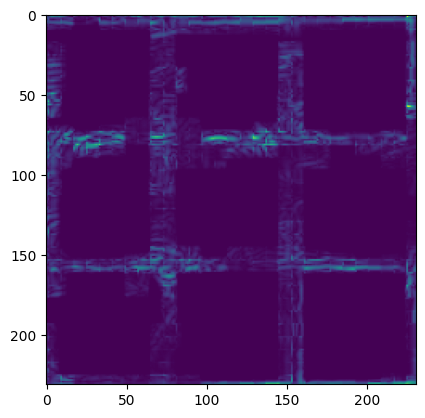

In [32]:
print(f"{br_diff.max()=}\n{br_diff.min()=}\n{np.median(br_diff)=}")
mask_x = np.maximum(br_diff, 0)[:, 1:] * bx
mask_y = np.maximum(br_diff, 0)[1:, :] * by
mask = np.sqrt(mask_x[1:, :] ** 2 + mask_y[:, 1:] ** 2)
mask = (mask - mask.min()) / mask.ptp()
plt.imshow(mask)

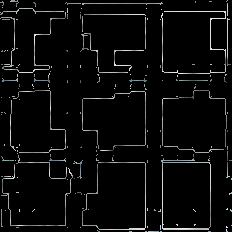

In [33]:
grid = rgb_original.copy()
a = np.round(br_diff).astype(np.uint8)
b = cv.medianBlur(a, 3)
grid[b - a < 10] = 0
Image.fromarray(grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


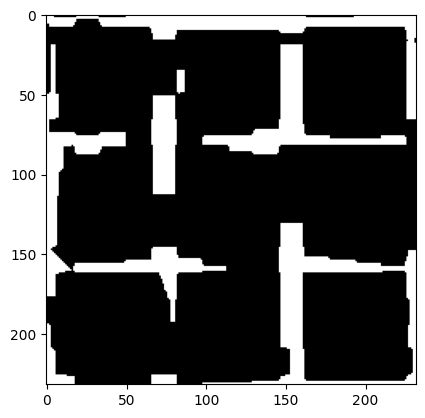

In [34]:
grid = rgb_original.astype(int)[..., 2] - rgb_original.astype(int)[..., 0]
grid[grid <= 10] = 0
grid = ((grid - grid.min()) / grid.ptp())
grid = np.expand_dims(grid, axis=2) * rgb_original
plt.imshow(grid)

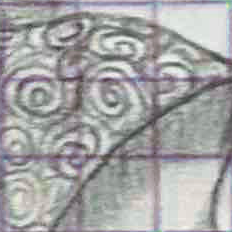

In [35]:
original_hue = hls_original[..., 0].astype(int)
grid_hue = grid[..., 0]
# original_hue = (grid_hue + gridless_hue) / 2 --> gridless_hue = 2 * original_hue - grid_hue
gridless_hue = 2 * original_hue - grid_hue
gridless = hls_original.copy()
gridless[..., 0] = gridless_hue
gridless = cv.cvtColor(gridless, cv.COLOR_HLS2RGB)
Image.fromarray(gridless)

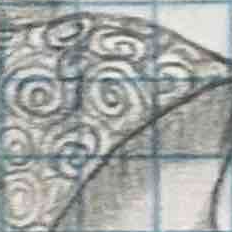

In [36]:
Image.fromarray(cv.cvtColor(hls_original, cv.COLOR_HLS2RGB))